# Horizontal Mean difference and RMS: model versus observations

`mom6_tools.horizontalMean` collection of functions for computing horizontal mean of **difference** and **rms** (model versus obs). This notebook servers as an example on how to compute the following operations:


#### $$diff(t,z)= A_{TOT}(z)^{-1}\sum_{i=1}^n (y_i(z) - \hat{y_i(x,y,z)}) A_i(z),$$

#### $$rms(t,z)= [A_{TOT}(z)^{-1}\sum_{i=1}^n (y_i(z) - \hat{y_i}(x,y,z))^2 A_i(z)]^{1/2},$$

where $y$(z) is the model output at point $i$ and level $z$, $\hat{y}(z)$ is the observation at point $i$ and level $z$, $n$ is the total number of grid points in the horizontal (i.e., NX x NY), $A_{i}(z)$ is the area of grid cell $i$ at level $z$, and $A_{TOT}(z) = \sum_{i=1}^n A_i(z)$ is the total ocean area at level z. 

**Important**:

With the porpuses of calculating T and S changes at specific regions, $A_{i}(z)$ is multiplied by basin masks generated via ``mom6_tools.m6toolbox.genBasinMasks``. Click [here](https://gist.github.com/gustavo-marques/655f725ed77596db7460eaa67c91f43d) to see maps for the regions over which the above reductions are applied.

The table below summarizes the results of this notebook:
<a id='table'></a>

| Region   | Temperature   |  Salinity |
|----------|:-------------:|----------:|
| Global       |  [diff](#Global_temp_diff), [rms](#Global_temp_rms) | [diff](#Global_salt_diff), [rms](#Global_salt_rms) |
| Persian Gulf | [diff](#PersianGulf_temp_diff), [rms](#PersianGulf_temp_rms) | [diff](#PersianGulf_salt_diff), [rms](#PersianGulf_salt_rms) |
| Red Sea      | [diff](#RedSea_temp_diff), [rms](#RedSea_temp_rms) | [diff](#RedSea_salt_diff), [rms](#RedSea_salt_rms) |
| Black Sea    | [diff](#BlackSea_temp_diff), [rms](#BlackSea_temp_rms) | [diff](#BlackSea_salt_diff), [rms](#BlackSea_salt_rms) |
| Med Sea      | [diff](#MedSea_temp_diff), [rms](#MedSea_temp_rms) | [diff](#MedSea_salt_diff), [rms](#MedSea_salt_rms) |
| Baltic Sea   | [diff](#BalticSea_temp_diff), [rms](#BalticSea_temp_rms) | [diff](#BalticSea_salt_diff), [rms](#BalticSea_salt_rms) |
| Hudson Bay   | [diff](#HudsonBay_temp_diff), [rms](#HudsonBay_temp_rms) | [diff](#HudsonBay_salt_diff), [rms](#HudsonBay_salt_rms) |
| Arctic       | [diff](#Arctic_temp_diff), [rms](#Arctic_temp_rms) | [diff](#Arctic_salt_diff), [rms](#Arctic_salt_rms) |
| Pacific      | [diff](#PacificOcean_temp_diff), [rms](#PacificOcean_temp_rms) | [diff](#PacificOcean_salt_diff), [rms](#PacificOcean_salt_rms) |
| Atlantic     | [diff](#AtlanticOcean_temp_diff), [rms](#AtlanticOcean_temp_rms) | [diff](#AtlanticOcean_salt_diff), [rms](#AtlanticOcean_salt_rms) |
| Indian       | [diff](#IndianOcean_temp_diff), [rms](#IndianOcean_temp_rms) | [diff](#IndianOcean_salt_diff), [rms](#IndianOcean_salt_rms) |
| Southern     | [diff](#SouthernOcean_temp_diff), [rms](#SouthernOcean_temp_rms) | [diff](#SouthernOcean_salt_diff), [rms](#SouthernOcean_salt_rms) |

In [1]:
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.ClimoGenerator import ClimoGenerator
from mom6_tools.stats import HorizontalMeanDiff_da, HorizontalMeanRmse_da
from mom6_tools.m6plot import ztplot
from mom6_tools.m6toolbox import genBasinMasks
from IPython.display import display, Markdown, Latex
import yaml
import xarray as xr
import matplotlib
import numpy as np
%matplotlib inline

In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [3]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'], xrformat=True)

In [4]:
# Load the grid
grd = dcase.grid
# get ocean area
area = grd.area_t.where(grd.wet > 0)
# Get masking for different regions
depth = grd.depth_ocean.values
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon.values, grd.geolat.values, depth, xda=True)

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


In [5]:
# Create the climatology instance
climo = ClimoGenerator(diag_config_yml['Climo'], dcase)

In [6]:
# Compute the climatology dataset
dset_climo = climo.stage()

In [7]:
thetao_model = dset_climo['1Y'].thetao
salt_model = dset_climo['1Y'].so

In [8]:
# load PHC2 data
phc_path = '/glade/p/cesm/omwg/obs_data/phc/'
phc_temp = xr.open_mfdataset(phc_path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc', decode_times=False)
phc_salt = xr.open_mfdataset(phc_path+'PHC2_SALT_tx0.66v1_34lev_ann_avg.nc', decode_times=False)

In [9]:
# get theta and salt and rename coordinates to be the same as the model's
thetao_obs = phc_temp.TEMP.rename({'X': 'xh','Y': 'yh', 'depth': 'z_l'});
salt_obs = phc_salt.SALT.rename({'X': 'xh','Y': 'yh', 'depth': 'z_l'});
# set coordinates to the same as the model's
thetao_obs['xh'] = thetao_model.xh; thetao_obs['yh'] = thetao_model.yh; 
salt_obs['xh'] = salt_model.xh; salt_obs['yh'] = salt_model.yh; 

In [10]:
temp_diff = thetao_model - thetao_obs
salt_diff = salt_model - salt_obs

## Construct a 3D area with land values masked

In [11]:
area3d = np.repeat(area.values[np.newaxis, :, :], len(temp_diff.z_l), axis=0)
mask3d = xr.DataArray(area3d, dims=(temp_diff.dims[1:4]), coords= {temp_diff.dims[1]: temp_diff.z_l,
                                                                   temp_diff.dims[2]: temp_diff.yh,
                                                                   temp_diff.dims[3]: temp_diff.xh})
area3d_masked = mask3d.where(temp_diff[0,:] == temp_diff[0,:])

## Horizontal Mean difference (model - obs)

In [12]:
temp_bias = HorizontalMeanDiff_da(temp_diff,weights=area3d_masked, basins=basin_code)
salt_bias = HorizontalMeanDiff_da(salt_diff,weights=area3d_masked, basins=basin_code)

## Temperature

<a id=Global_temp_diff></a>

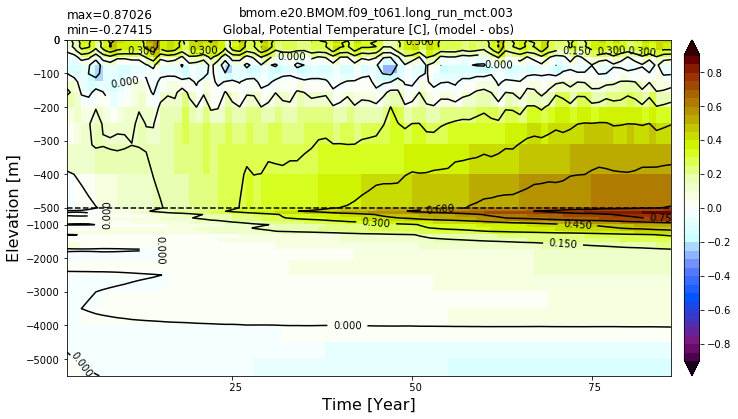

[top](#table)

***

<a id=PersianGulf_temp_diff></a>

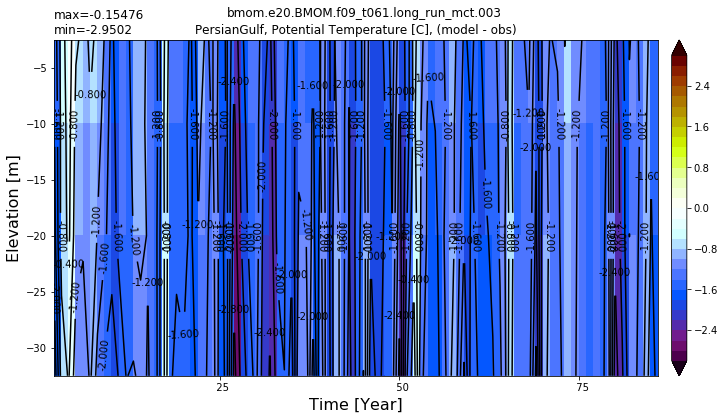

[top](#table)

***

<a id=RedSea_temp_diff></a>

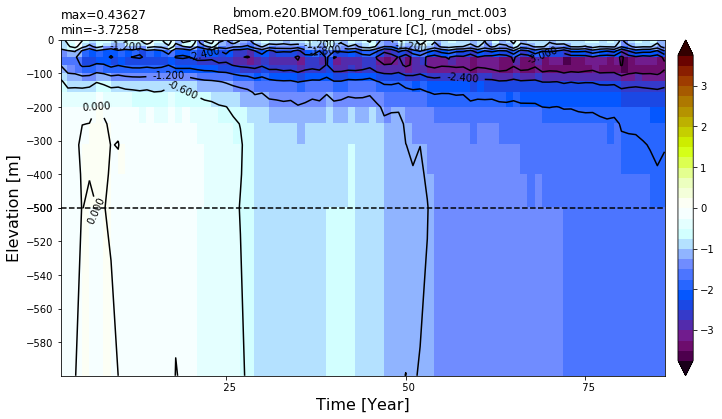

[top](#table)

***

<a id=BlackSea_temp_diff></a>

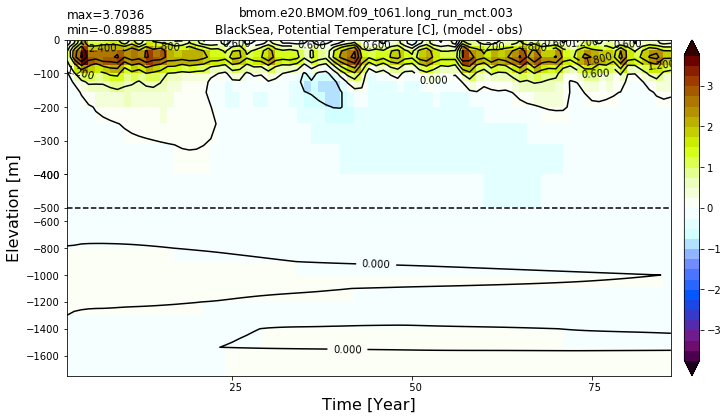

[top](#table)

***

<a id=MedSea_temp_diff></a>

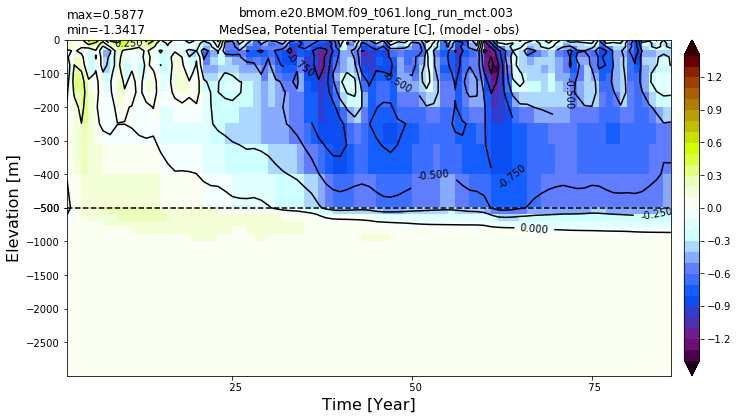

[top](#table)

***

<a id=BalticSea_temp_diff></a>

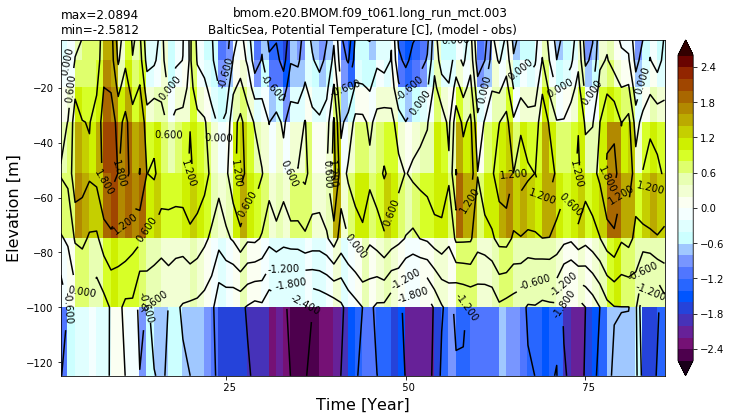

[top](#table)

***

<a id=HudsonBay_temp_diff></a>

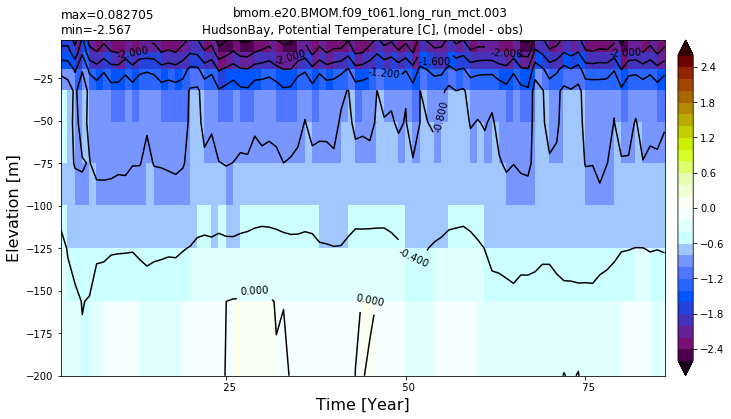

[top](#table)

***

<a id=Arctic_temp_diff></a>

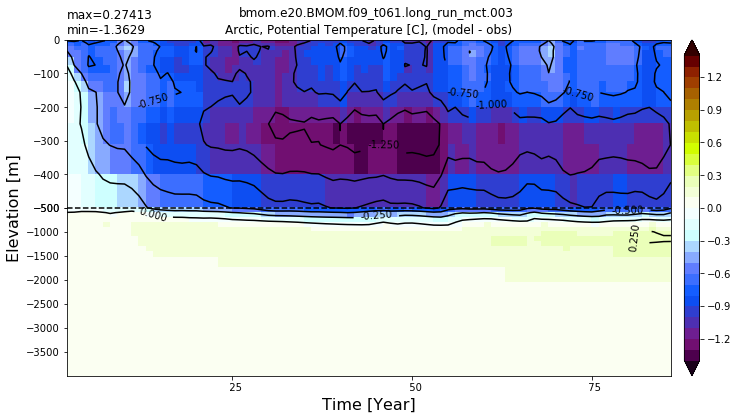

[top](#table)

***

<a id=PacificOcean_temp_diff></a>

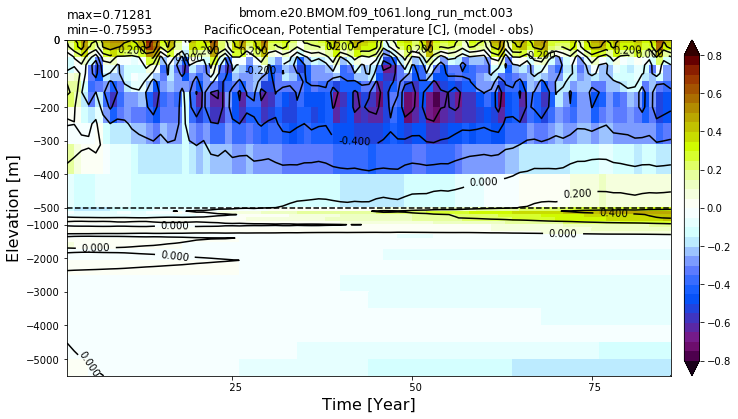

[top](#table)

***

<a id=AtlanticOcean_temp_diff></a>

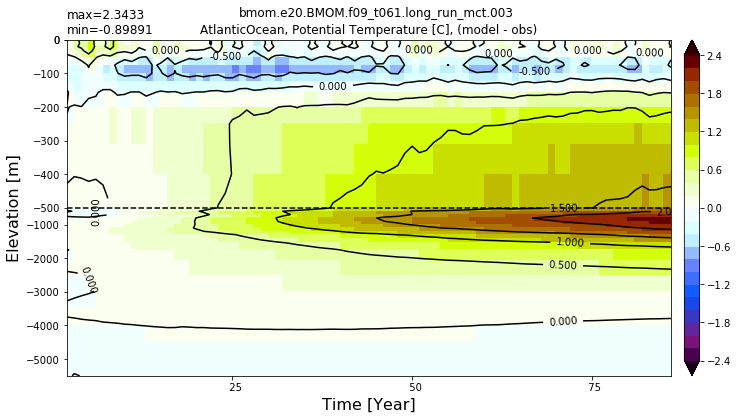

[top](#table)

***

<a id=IndianOcean_temp_diff></a>

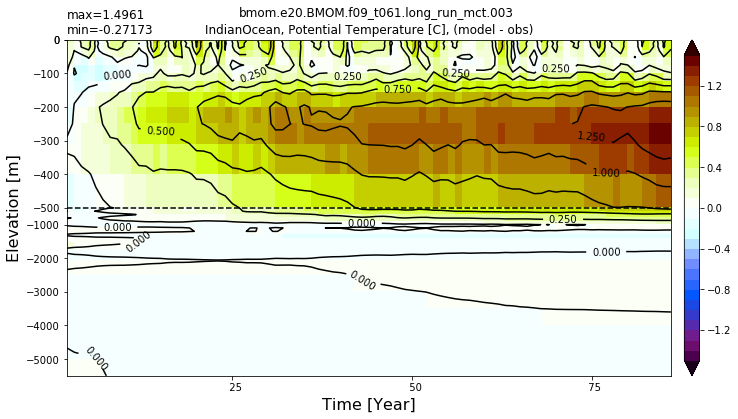

[top](#table)

***

<a id=SouthernOcean_temp_diff></a>

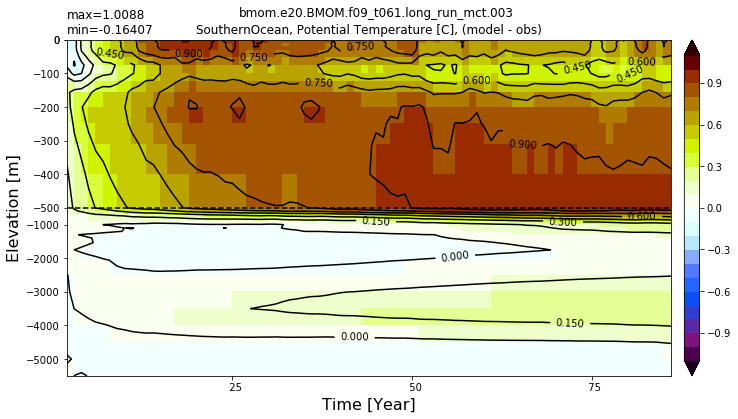

[top](#table)

***

In [13]:
for reg in temp_bias.region:
    # remove Nan's
    diff_reg = temp_bias.sel(region=reg).dropna('z_l')
    if diff_reg.z_l.max() <= 500.0:
      splitscale = None
    else:
      splitscale =  [0., -500., -diff_reg.z_l.max()]

    anchor = '<a id='+str(reg.values)+'_temp_diff></a>'
    display(Markdown(anchor))
    ztplot(diff_reg.values, diff_reg.time.values, diff_reg.z_l.values*-1, ignore=np.nan, splitscale=splitscale, suptitle=dcase._casename, contour=True,
           title= str(reg.values) + ', Potential Temperature [C], (model - obs)', extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=True); 
    display(Markdown('[top](#table)'))
    display(Markdown('***'))

## Salinity

<a id=Global_salt_diff></a>

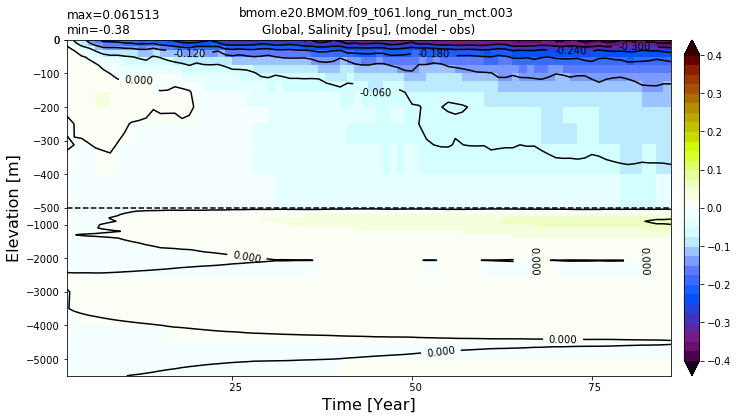

[top](#table)

***

<a id=PersianGulf_salt_diff></a>

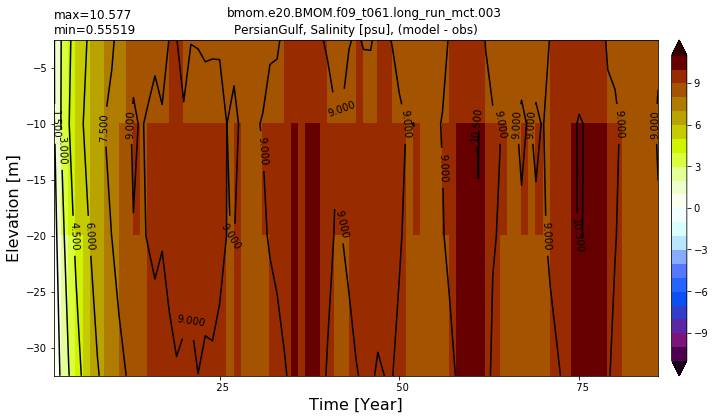

[top](#table)

***

<a id=RedSea_salt_diff></a>

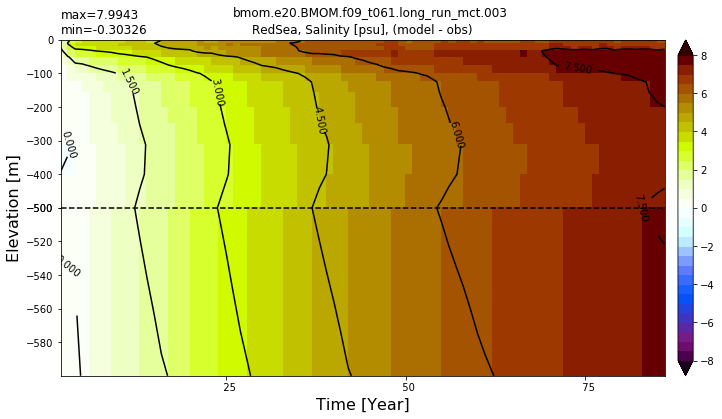

[top](#table)

***

<a id=BlackSea_salt_diff></a>

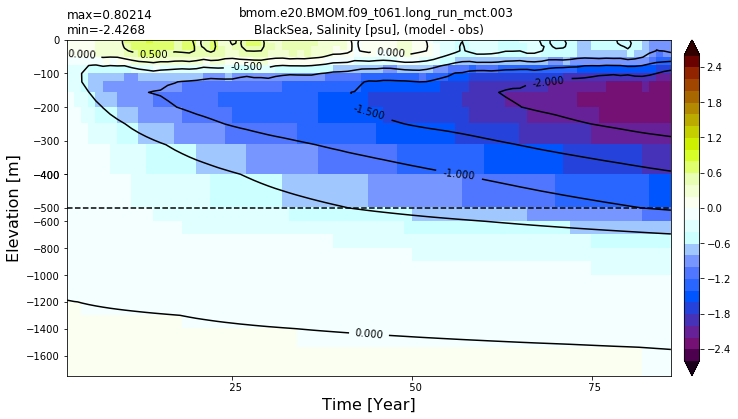

[top](#table)

***

<a id=MedSea_salt_diff></a>

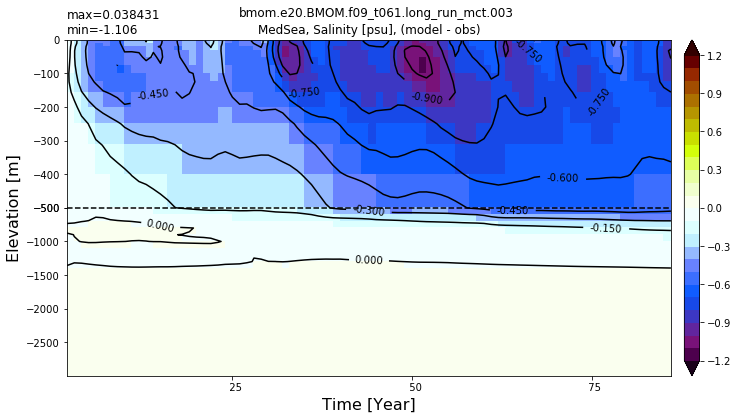

[top](#table)

***

<a id=BalticSea_salt_diff></a>

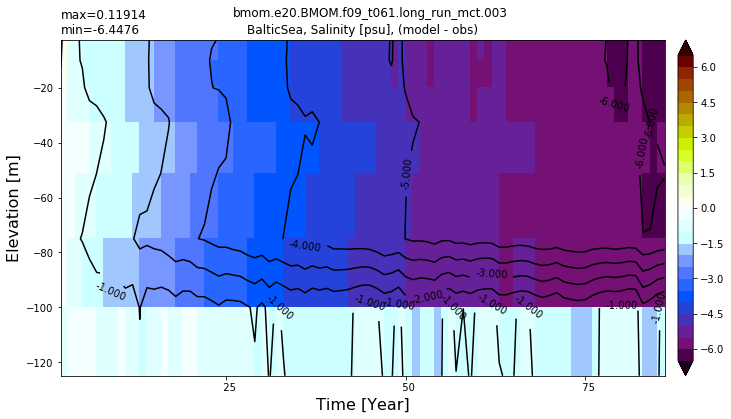

[top](#table)

***

<a id=HudsonBay_salt_diff></a>

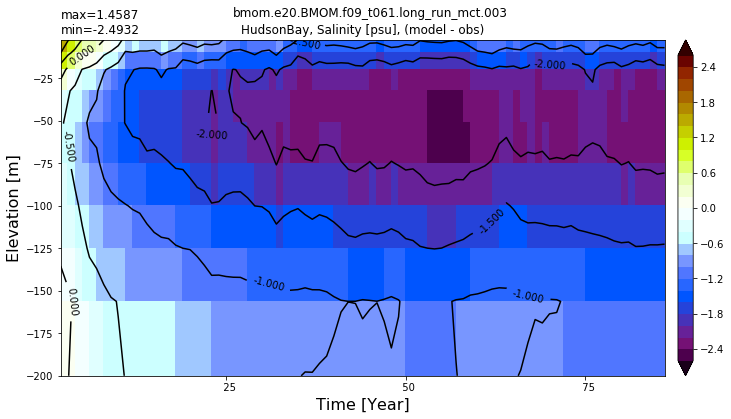

[top](#table)

***

<a id=Arctic_salt_diff></a>

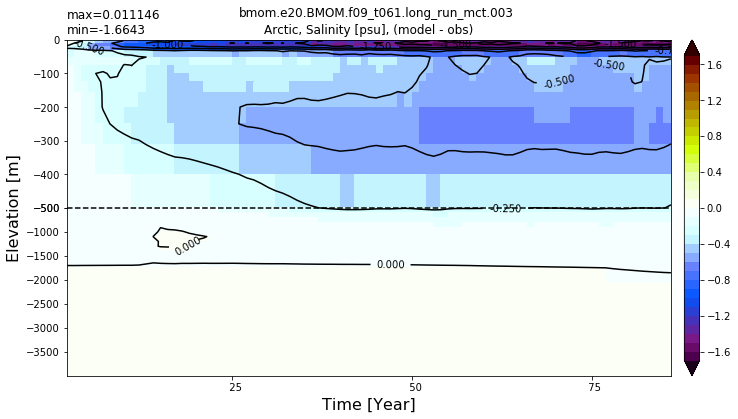

[top](#table)

***

<a id=PacificOcean_salt_diff></a>

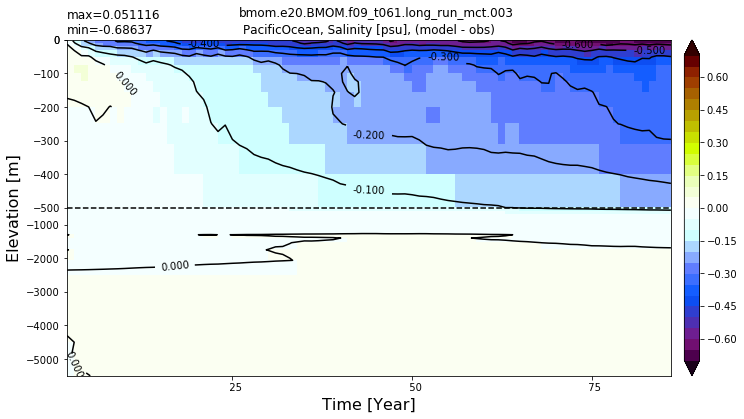

[top](#table)

***

<a id=AtlanticOcean_salt_diff></a>

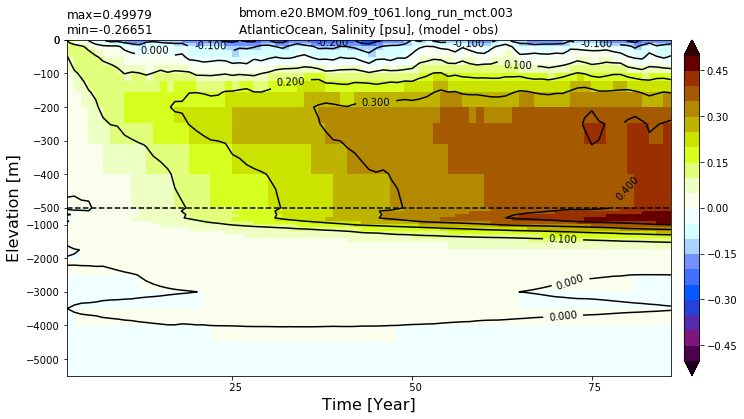

[top](#table)

***

<a id=IndianOcean_salt_diff></a>

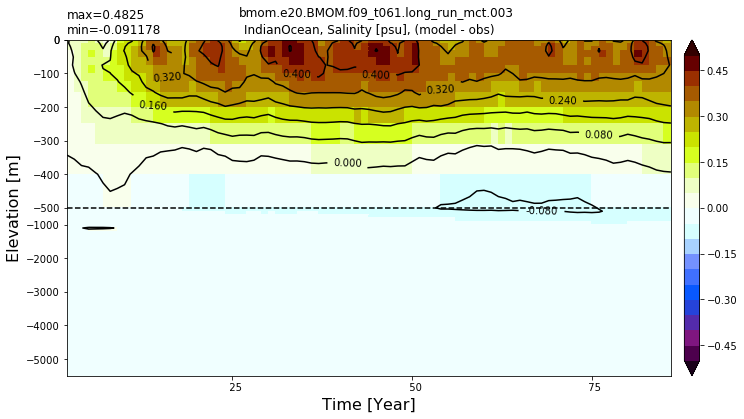

[top](#table)

***

<a id=SouthernOcean_salt_diff></a>

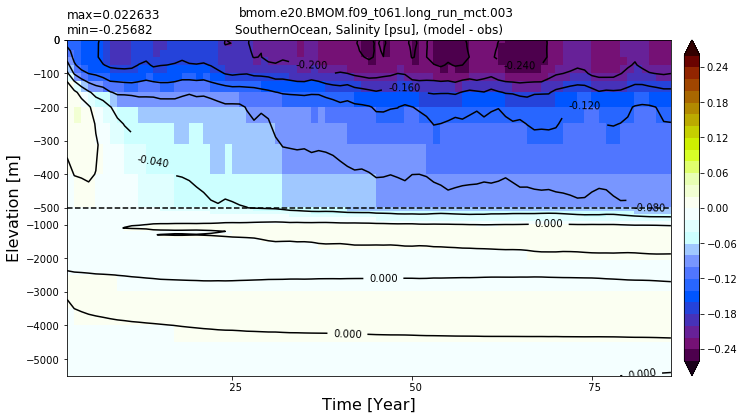

[top](#table)

***

In [14]:
for reg in salt_bias.region:
    # remove Nan's
    diff_reg = salt_bias.sel(region=reg).dropna('z_l')
    if diff_reg.z_l.max() <= 500.0:
      splitscale = None
    else:
      splitscale =  [0., -500., -diff_reg.z_l.max()]

    anchor = '<a id='+str(reg.values)+'_salt_diff></a>'
    display(Markdown(anchor))
    ztplot(diff_reg.values, diff_reg.time.values, diff_reg.z_l.values*-1, ignore=np.nan, splitscale=splitscale, suptitle=dcase._casename, contour=True,
           title= str(reg.values) + ', Salinity [psu], (model - obs)', extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=True); 
    display(Markdown('[top](#table)'))
    display(Markdown('***'))

## Horizontal Mean RMSe (model - obs)

In [15]:
temp_rms = HorizontalMeanRmse_da(temp_diff,weights=area3d_masked, basins=basin_code)
salt_rms = HorizontalMeanRmse_da(salt_diff,weights=area3d_masked, basins=basin_code)

## Temperature

<a id=Global_temp_rms></a>

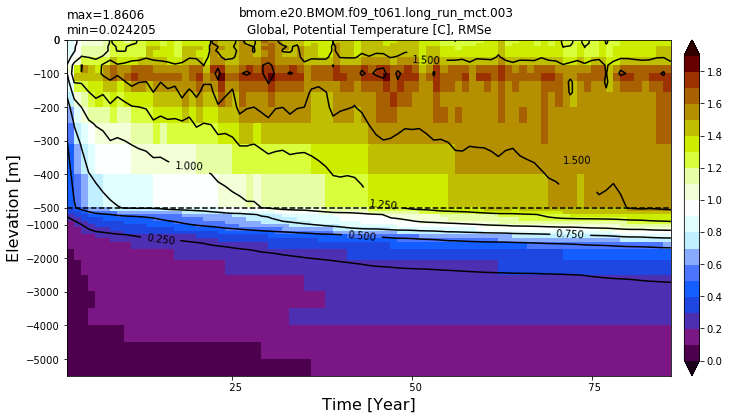

[top](#table)

***

<a id=PersianGulf_temp_rms></a>

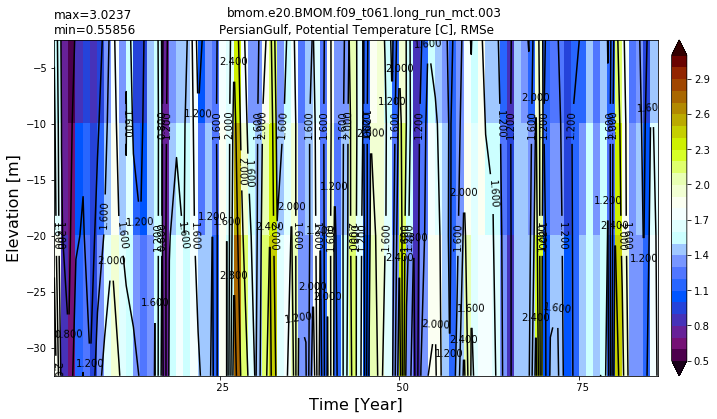

[top](#table)

***

<a id=RedSea_temp_rms></a>

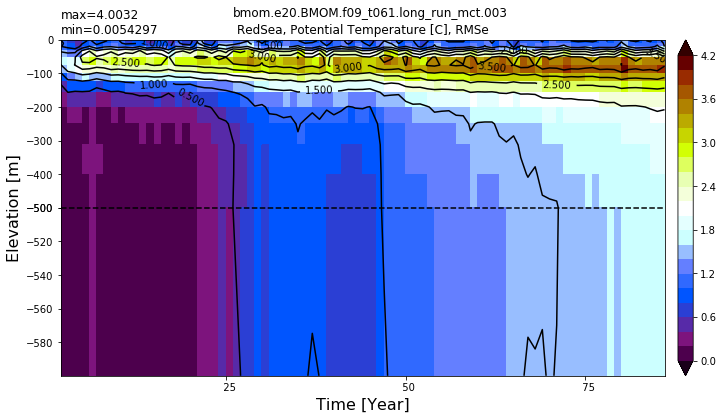

[top](#table)

***

<a id=BlackSea_temp_rms></a>

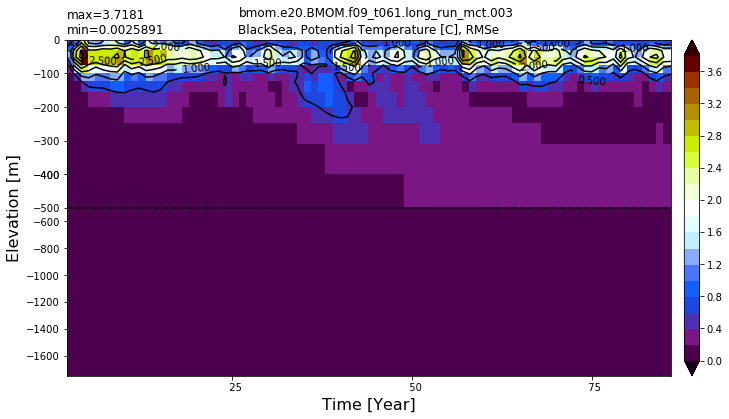

[top](#table)

***

<a id=MedSea_temp_rms></a>

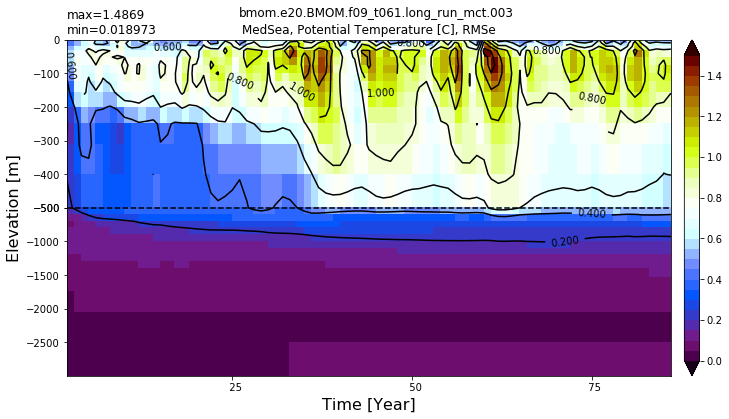

[top](#table)

***

<a id=BalticSea_temp_rms></a>

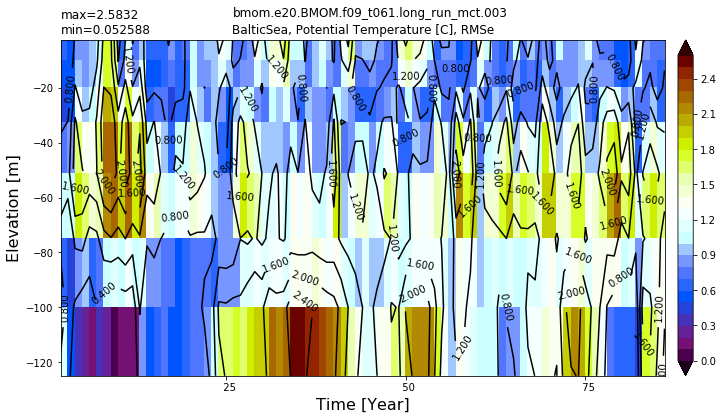

[top](#table)

***

<a id=HudsonBay_temp_rms></a>

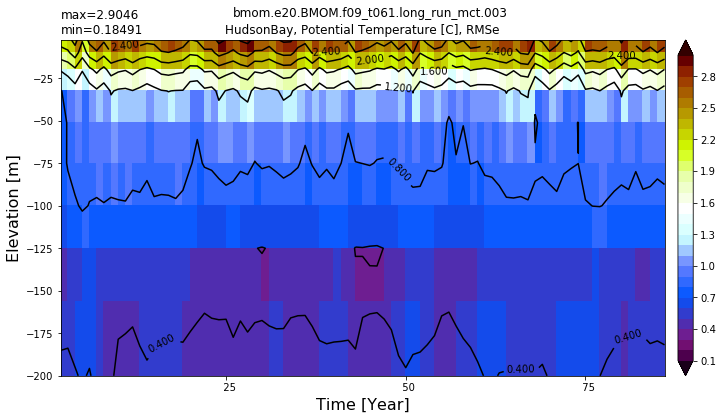

[top](#table)

***

<a id=Arctic_temp_rms></a>

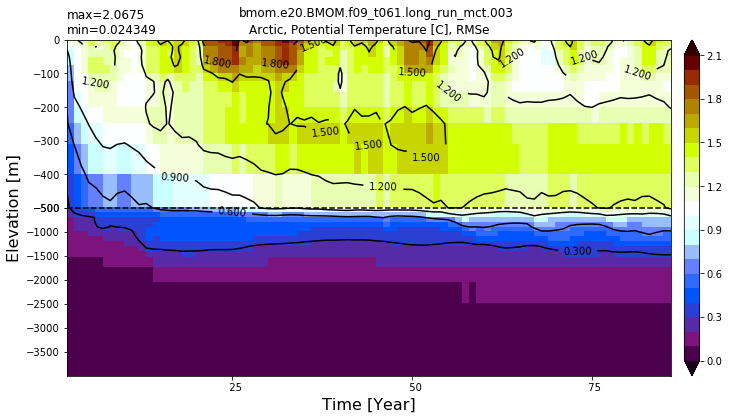

[top](#table)

***

<a id=PacificOcean_temp_rms></a>

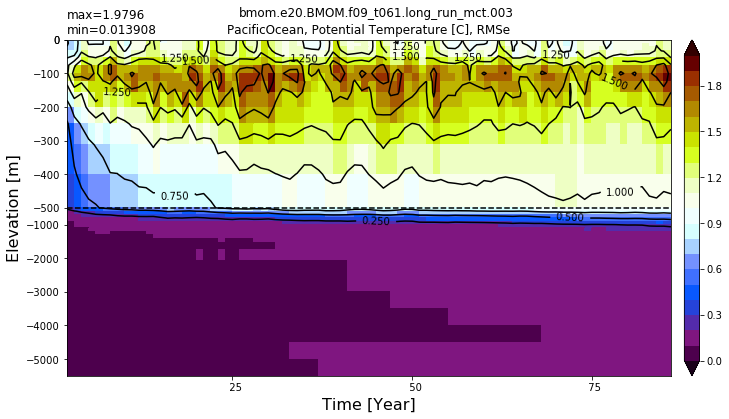

[top](#table)

***

<a id=AtlanticOcean_temp_rms></a>

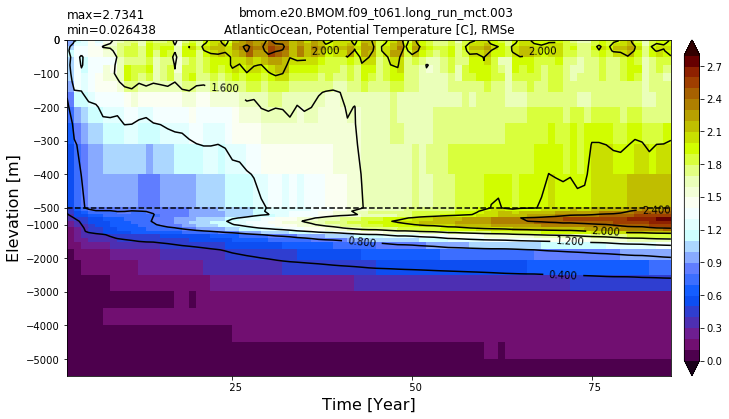

[top](#table)

***

<a id=IndianOcean_temp_rms></a>

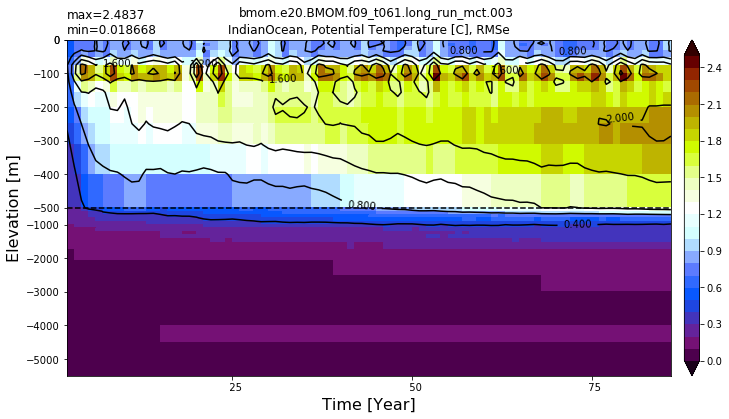

[top](#table)

***

<a id=SouthernOcean_temp_rms></a>

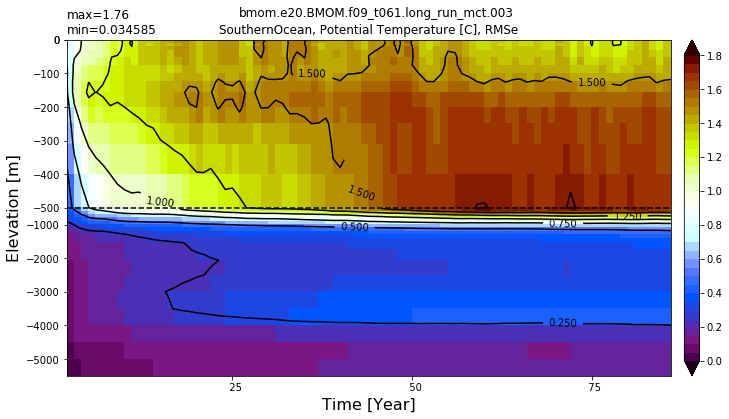

[top](#table)

***

In [16]:
for reg in temp_rms.region:
    # remove Nan's
    diff_reg = temp_rms.sel(region=reg).dropna('z_l')
    if diff_reg.z_l.max() <= 500.0:
      splitscale = None
    else:
      splitscale =  [0., -500., -diff_reg.z_l.max()]

    anchor = '<a id='+str(reg.values)+'_temp_rms></a>'
    display(Markdown(anchor))
    ztplot(diff_reg.values, diff_reg.time.values, diff_reg.z_l.values*-1, ignore=np.nan, splitscale=splitscale, suptitle=dcase._casename, contour=True,
           title= str(reg.values) + ', Potential Temperature [C], RMSe', extend='both', colormap='dunnePM', autocenter=False, tunits='Year', show=True); 
    display(Markdown('[top](#table)'))
    display(Markdown('***'))

## Salinity

<a id=Global_salt_rms></a>

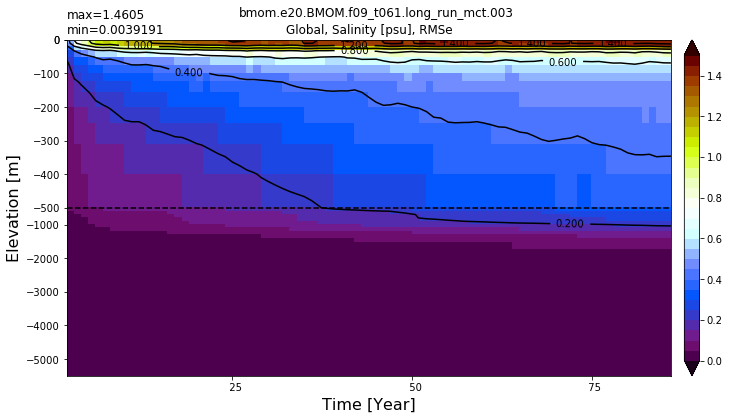

[top](#table)

***

<a id=PersianGulf_salt_rms></a>

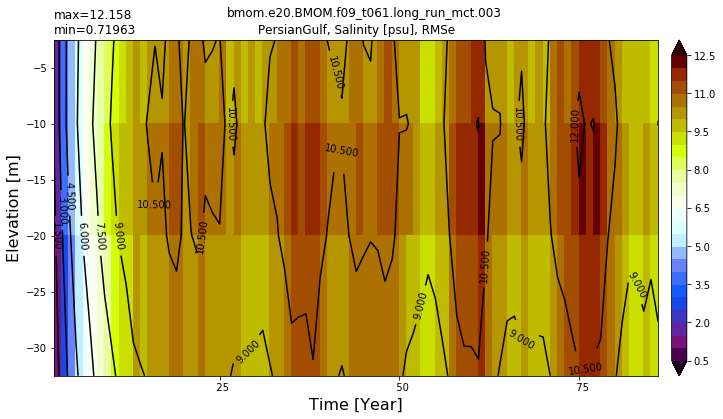

[top](#table)

***

<a id=RedSea_salt_rms></a>

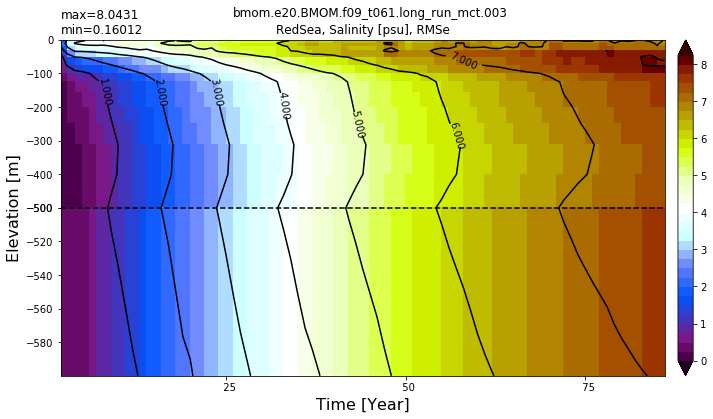

[top](#table)

***

<a id=BlackSea_salt_rms></a>

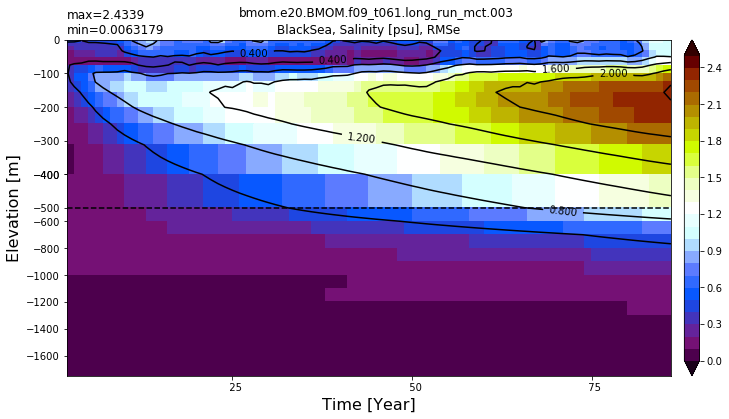

[top](#table)

***

<a id=MedSea_salt_rms></a>

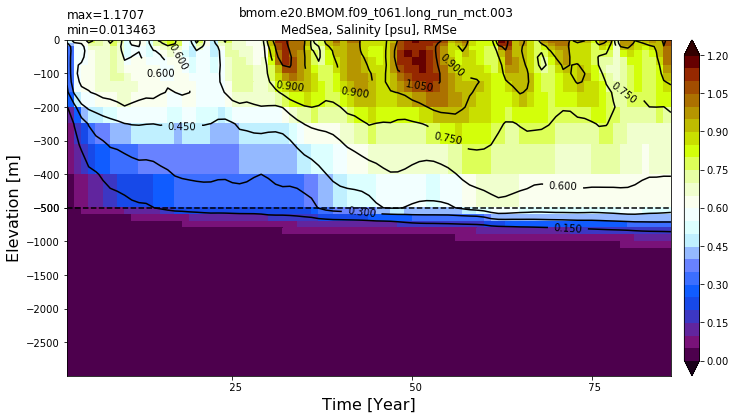

[top](#table)

***

<a id=BalticSea_salt_rms></a>

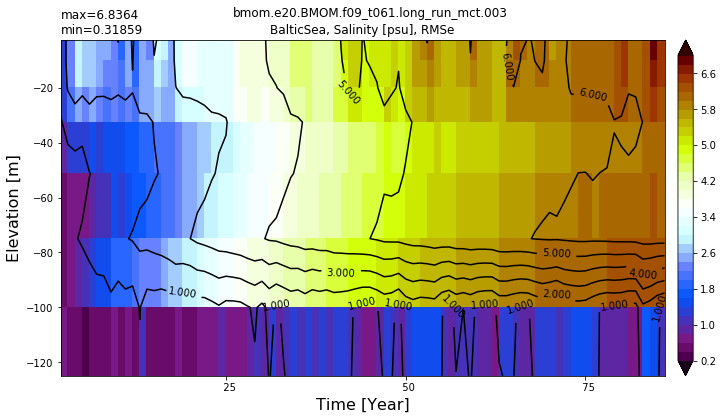

[top](#table)

***

<a id=HudsonBay_salt_rms></a>

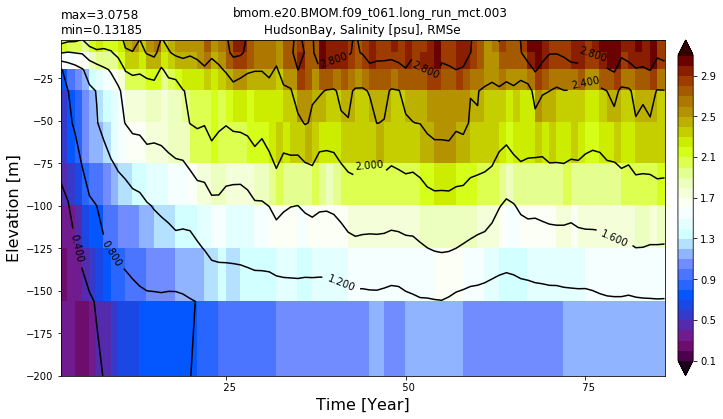

[top](#table)

***

<a id=Arctic_salt_rms></a>

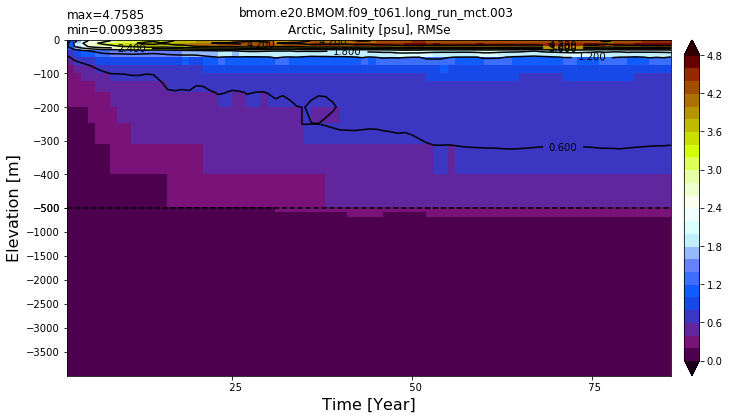

[top](#table)

***

<a id=PacificOcean_salt_rms></a>

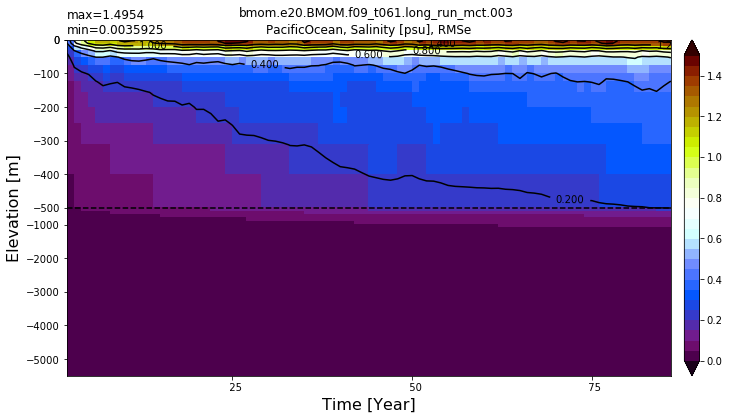

[top](#table)

***

<a id=AtlanticOcean_salt_rms></a>

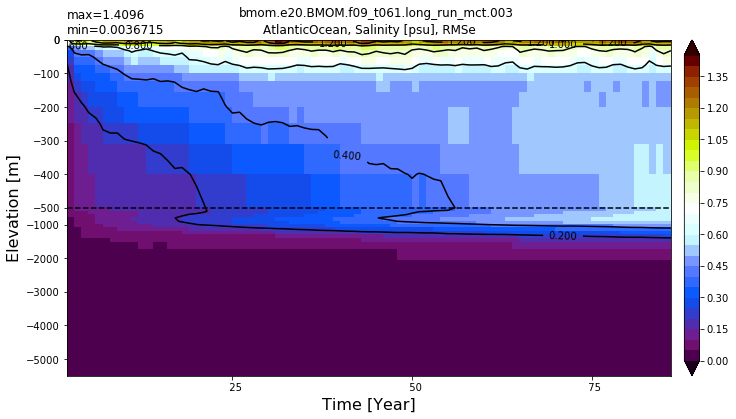

[top](#table)

***

<a id=IndianOcean_salt_rms></a>

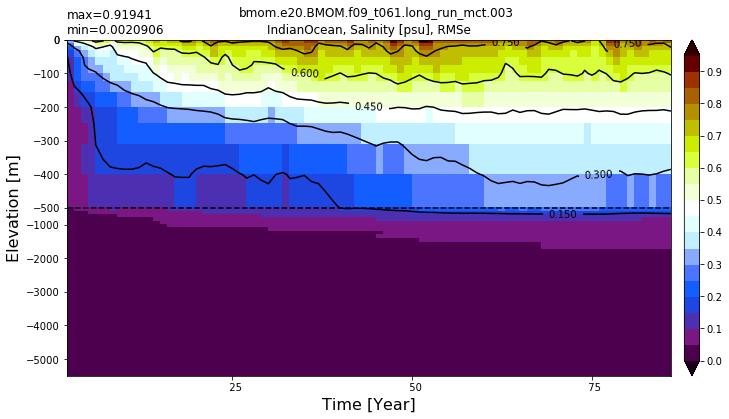

[top](#table)

***

<a id=SouthernOcean_salt_rms></a>

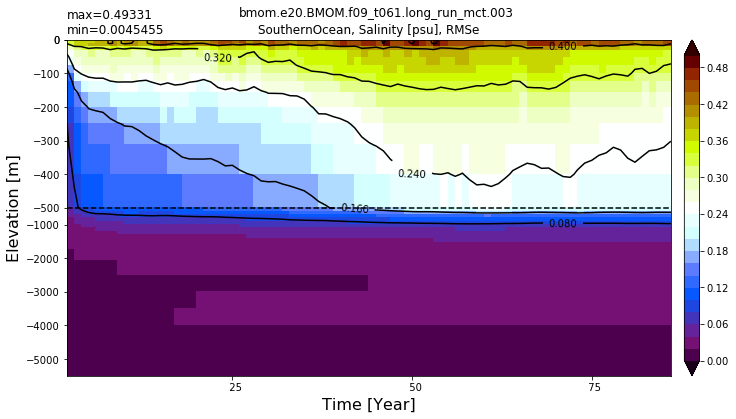

[top](#table)

***

In [17]:
for reg in salt_rms.region:
    # remove Nan's
    diff_reg = salt_rms.sel(region=reg).dropna('z_l')
    if diff_reg.z_l.max() <= 500.0:
      splitscale = None
    else:
      splitscale =  [0., -500., -diff_reg.z_l.max()]

    anchor = '<a id='+str(reg.values)+'_salt_rms></a>'
    display(Markdown(anchor))
    ztplot(diff_reg.values, diff_reg.time.values, diff_reg.z_l.values*-1, ignore=np.nan, splitscale=splitscale, suptitle=dcase._casename, contour=True,
           title= str(reg.values) + ', Salinity [psu], RMSe', extend='both', colormap='dunnePM', autocenter=False, tunits='Year', show=True); 
    display(Markdown('[top](#table)'))
    display(Markdown('***'))